In [24]:
import cv2
import glob
import sys
import os
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from functools import partial
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter

def load_file(path,x,y,x_1,y_1):
    files = glob.glob(path+'./*.jpg')
    if not files:
        print("Chck Phath")
        sys.exit()
    img = []
    for index, i in enumerate(tqdm.tqdm((files))):
        im = cv2.imread(i, cv2.IMREAD_GRAYSCALE)[y:y_1, x:x_1]
        if index == 0:
            ref_img = im
        img.append(np.stack([im, ref_img], axis = 2))
    return np.array(img)

features = load_file('../data/ML/', 192, 350,292,450)
target = np.array(pd.read_csv('../data/ML/target.csv', encoding='CP949'))[:,3]
min_max_scaler  = MinMaxScaler()
target = min_max_scaler.fit_transform(target.reshape(-1, 1))
target = savgol_filter(target.flatten(),201,1).reshape(-1, 1)


100%|██████████| 3638/3638 [00:20<00:00, 174.46it/s]


In [25]:
X_train,  X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.15, random_state=0)
X_train = X_train /255.0
X_valid = X_valid / 255.0


In [26]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[100, 100, 2]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=1),
])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 200, 200, 64)      6336      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 128)     73856     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 128)     147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 256)       295168    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 256)      

In [27]:
model.compile(loss="mse", optimizer="RMSprop", metrics=["mse"])
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))
score = model.evaluate(X_valid, y_valid)

Train on 3092 samples, validate on 546 samples
Epoch 1/30
3092/3092 [==============================] - 4s 1ms/sample - loss: 33.2136 - mse: 33.2136 - val_loss: 0.0069 - val_mse: 0.0069

In [28]:
training_loss = history.history["loss"]
test_loss = history.history["val_loss"]
epoch_count = range(1, len(training_loss)+1)

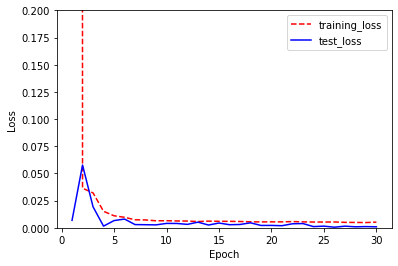

In [29]:
import matplotlib.pyplot as plt
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["training_loss", "test_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0,0.2)

# DIC_training_loss=np.load('DIC_training_loss.npy')
# DIC_test_loss=np.load('DIC_test_loss.npy')
# plt.plot(epoch_count,DIC_training_loss,"b--")
# # plt.plot(epoch_count,DIC_test_loss)
# plt.show()
plt.savefig('loss.png',dpi=300, bbox_inches='tight')

In [30]:
predicted_target = model.predict(features/255)

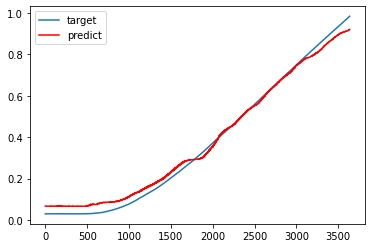

In [31]:
plt.plot(target,label='target')
plt.plot(predicted_target,color='red',label='predict')
plt.legend()

In [ ]:
model.save('ml.h5')

In [ ]:
np.save('ml_training_loss',training_loss)
np.save('test_loss',test_loss)

In [ ]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[100, 100, 2]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="sigmoid"))

In [ ]:
model.summary()

In [ ]:
model.compile(loss="mse", optimizer="RMSprop", metrics=["mse"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_valid, y_valid)

In [ ]:
import cv2
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
min= MinMaxScaler()


img = features[1][:,:,0]

img2 = features[3200][:,:,0]


fig, ax = plt.subplots()
sns.kdeplot(data=img.ravel(),color='red',label='Ref',ax=ax)
sns.kdeplot(data=img2.ravel(),label='Deformed',ax=ax)

plt.ylabel('number of pixel')
plt.xlabel('pixel value')
# ax.set_xlim(80,100)
plt.savefig('ml_hist.png',bbox='tight')

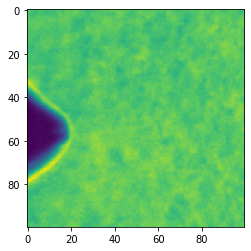

In [32]:
plt.imshow(features[0,:,:,1])

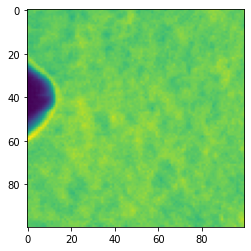

In [33]:
plt.imshow(features[3000,:,:,0])